Por:
- *Vania Janet Raya Rios*
- *Imanol Mendoza Saenz de Buruaga*
- *Mauricio Acosta*

# Análisis Exploratorio de Datos Bancarios
## Predicción de Quiebra Bancaria usando FDIC y FFIEC

**Objetivo:** Implementar un modelo de minería de datos para generar un Análisis de Supervivencia y predecir la quiebra de instituciones bancarias en Estados Unidos.

**Fuentes de Datos:**
- **FDIC (Federal Deposit Insurance Corporation):** Lista de bancos quebrados
- **FFIEC (Federal Financial Institutions Examination Council):** Reportes financieros detallados (Call Reports)
- **Variable de unión:** CERT (Certificado de banco)

In [132]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os
import glob
import csv
import itertools

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librerías importadas correctamente")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")


Librerías importadas correctamente
Pandas version: 2.3.3
Numpy version: 2.3.4


## 1. Carga de Datos de FDIC (Bancos Quebrados)

Primero cargaremos la lista de bancos quebrados de la FDIC para identificar nuestras etiquetas (target variable).

In [133]:
# Cargar datos de bancos quebrados de FDIC
# URL: https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/
# Los datos estan en download-data.csv

# Intentar cargar desde el archivo existente con diferentes encodings
try:
    # Intentar primero con latin-1 (común en archivos de gobierno de EE.UU.)
    try:
        fdic_failed = pd.read_csv('download-data.csv', encoding='latin-1')
    except:
        # Si falla, intentar con otros encodings
        try:
            fdic_failed = pd.read_csv('download-data.csv', encoding='iso-8859-1')
        except:
            fdic_failed = pd.read_csv('download-data.csv', encoding='cp1252')
    
    print("✓ Datos de FDIC cargados exitosamente")
    print(f"Dimensiones: {fdic_failed.shape}")
    print(f"\nColumnas disponibles:\n{fdic_failed.columns.tolist()}")
    
except FileNotFoundError:
    print("Archivo download-data.csv no encontrado. Descargando desde FDIC...")
    # URL de la lista de bancos quebrados de FDIC
    url = "https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/banklist.csv"
    fdic_failed = pd.read_csv(url)
    fdic_failed.to_csv('download-data.csv', index=False, encoding='utf-8')
    print("✓ Datos descargados y guardados")
    print(f"Dimensiones: {fdic_failed.shape}")

✓ Datos de FDIC cargados exitosamente
Dimensiones: (572, 7)

Columnas disponibles:
['Bank Name\xa0', 'City\xa0', 'State\xa0', 'Cert\xa0', 'Acquiring Institution\xa0', 'Closing Date\xa0', 'Fund']


In [134]:
# Limpiar nombres de columnas (eliminar espacios y caracteres especiales)
fdic_failed.columns = fdic_failed.columns.str.strip().str.replace('\xa0', '').str.replace(' ', '_')

print("✓ Nombres de columnas limpiados:")
print(fdic_failed.columns.tolist())

# Mostrar información del dataset
print(f"\n Resumen del Dataset FDIC:")
print(f"   Registros: {len(fdic_failed):,}")
print(f"   Período: {fdic_failed['Closing_Date'].min()} a {fdic_failed['Closing_Date'].max()}")
print(f"\n   Columnas:")
for i, col in enumerate(fdic_failed.columns, 1):
    print(f"   {i}. {col}")

✓ Nombres de columnas limpiados:
['Bank_Name', 'City', 'State', 'Cert', 'Acquiring_Institution', 'Closing_Date', 'Fund']

 Resumen del Dataset FDIC:
   Registros: 572
   Período: 1-Aug-08 a 9-Sep-11

   Columnas:
   1. Bank_Name
   2. City
   3. State
   4. Cert
   5. Acquiring_Institution
   6. Closing_Date
   7. Fund


In [135]:
# Exploración inicial de bancos quebrados
print("ANÁLISIS DE BANCOS QUEBRADOS (FDIC)")

# Información básica
print(f"\nTotal de bancos quebrados: {len(fdic_failed)}")
print(f"\nPrimeros registros:")
fdic_failed.head(10)

ANÁLISIS DE BANCOS QUEBRADOS (FDIC)

Total de bancos quebrados: 572

Primeros registros:


,Bank_Name,City,State,Cert,Acquiring_Institution,Closing_Date,Fund
0,The Santa Anna National Bank,Santa Anna,TX,5520,Coleman County State Bank,27-Jun-25,10549
1,Pulaski Savings Bank,Chicago,IL,28611,Millennium Bank,17-Jan-25,10548
2,First National Bank of Lindsay,Lindsay,OK,4134,First Bank & Trust Co.,18-Oct-24,10547
3,Republic First Bank dba Republic Bank,Philadelphia,PA,27332,"Fulton Bank, National Association",26-Apr-24,10546
4,Citizens Bank,Sac City,IA,8758,Iowa Trust & Savings Bank,3-Nov-23,10545
5,Heartland Tri-State Bank,Elkhart,KS,25851,"Dream First Bank, N.A.",28-Jul-23,10544
6,First Republic Bank,San Francisco,CA,59017,"JPMorgan Chase Bank, N.A.",1-May-23,10543
7,Signature Bank,New York,NY,57053,"Flagstar Bank, N.A.",12-Mar-23,10540
8,Silicon Valley Bank,Santa Clara,CA,24735,FirstCitizens Bank & Trust Company,10-Mar-23,10539
9,Almena State Bank,Almena,KS,15426,Equity Bank,23-Oct-20,10538


In [136]:
# Información del dataset
print(fdic_failed.info())

fdic_failed.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Bank_Name              572 non-null    object
 1   City                   572 non-null    object
 2   State                  572 non-null    object
 3   Cert                   572 non-null    int64 
 4   Acquiring_Institution  572 non-null    object
 5   Closing_Date           572 non-null    object
 6   Fund                   572 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 31.4+ KB
None


,Bank_Name,City,State,Cert,Acquiring_Institution,Closing_Date,Fund
count,572,572,572,572.000000,572,572,572.000000
unique,553,438,44,NaN,306,267,NaN
top,First State Bank,Chicago,GA,NaN,No Acquirer,30-Oct-09,NaN
freq,3,21,93,NaN,31,9,NaN
mean,NaN,NaN,NaN,31553.940559,NaN,NaN,10044.863636
std,NaN,NaN,NaN,16498.371919,NaN,NaN,1108.318974
min,NaN,NaN,NaN,91.000000,NaN,NaN,4645.000000
25%,NaN,NaN,NaN,20025.750000,NaN,NaN,10118.750000
50%,NaN,NaN,NaN,32016.500000,NaN,NaN,10261.500000
75%,NaN,NaN,NaN,35360.000000,NaN,NaN,10404.250000


In [137]:
# Verificar valores nulos
print("\nValores nulos por columna:")
null_counts = fdic_failed.isnull().sum()
null_percentage = (null_counts / len(fdic_failed)) * 100
null_df = pd.DataFrame({
    'Columna': null_counts.index,
    'Valores Nulos': null_counts.values,
    'Porcentaje': null_percentage.values
})
null_df[null_df['Valores Nulos'] > 0].sort_values('Valores Nulos', ascending=False)


Valores nulos por columna:


,Columna,Valores Nulos,Porcentaje


## 2. Análisis Temporal de Quiebras Bancarias

In [138]:
# Convertir fecha de cierre a datetime si existe la columna
date_columns = [col for col in fdic_failed.columns if 'date' in col.lower() or 'closing' in col.lower()]
print(f"Columnas de fecha detectadas: {date_columns}")

# Intentar identificar la columna de fecha de cierre
if len(date_columns) > 0:
    date_col = date_columns[0]
    fdic_failed[date_col] = pd.to_datetime(fdic_failed[date_col], errors='coerce')
    
    # Extraer año y mes
    fdic_failed['year'] = fdic_failed[date_col].dt.year
    fdic_failed['month'] = fdic_failed[date_col].dt.month
    fdic_failed['quarter'] = fdic_failed[date_col].dt.quarter
    
    print(f"\nRango temporal:")
    print(f"   Primer quiebra: {fdic_failed[date_col].min()}")
    print(f"   Última quiebra: {fdic_failed[date_col].max()}")
    print(f"   Período: {fdic_failed['year'].min()} - {fdic_failed['year'].max()}")
else:
    print("No se encontró columna de fecha. Verificar estructura del dataset.")

Columnas de fecha detectadas: ['Closing_Date']

Rango temporal:
   Primer quiebra: 2000-10-13 00:00:00
   Última quiebra: 2025-06-27 00:00:00
   Período: 2000 - 2025


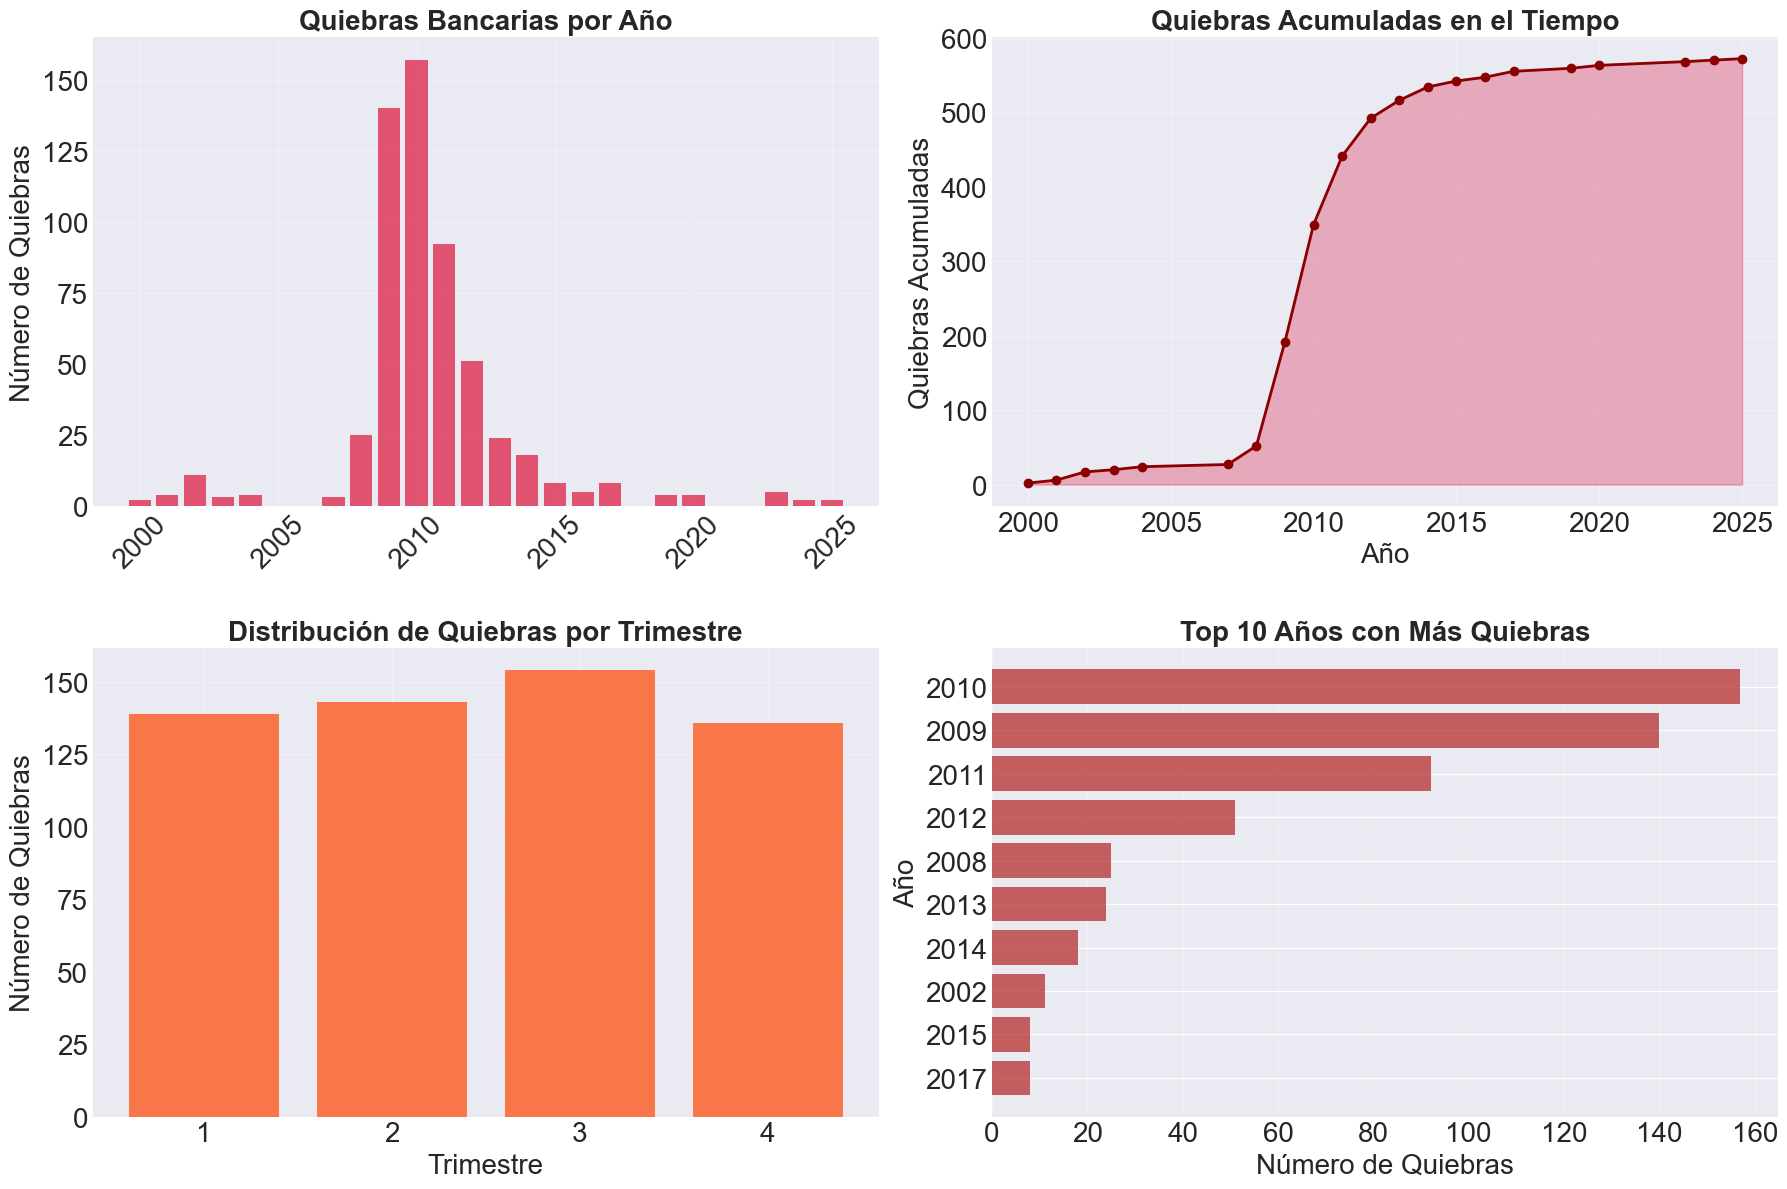


Estadísticas temporales:
   Año con más quiebras: 2010 (157 quiebras)
   Promedio anual: 27.2 quiebras)
   Mediana anual: 5.0 quiebras


In [139]:
# Visualización de quiebras por año
if 'year' in fdic_failed.columns:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Quiebras por año
    failures_by_year = fdic_failed['year'].value_counts().sort_index()
    axes[0, 0].bar(failures_by_year.index, failures_by_year.values, color='crimson', alpha=0.7)
    axes[0, 0].set_xlabel(' ', fontsize=20)
    axes[0, 0].set_ylabel('Número de Quiebras', fontsize=20)
    axes[0, 0].set_title('Quiebras Bancarias por Año', fontsize=20, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45, labelsize=20)
    axes[0, 0].tick_params(axis='y', labelsize=20)
    
    # 2. Quiebras acumuladas
    cumulative = failures_by_year.cumsum()
    axes[0, 1].plot(cumulative.index, cumulative.values, linewidth=2, color='darkred', marker='o')
    axes[0, 1].fill_between(cumulative.index, cumulative.values, alpha=0.3, color='crimson')
    axes[0, 1].set_xlabel('Año', fontsize=20)
    axes[0, 1].set_ylabel('Quiebras Acumuladas', fontsize=20)
    axes[0, 1].set_title('Quiebras Acumuladas en el Tiempo', fontsize=20, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(labelsize=20)
    
    # 3. Quiebras por trimestre
    if 'quarter' in fdic_failed.columns:
        quarter_dist = fdic_failed['quarter'].value_counts().sort_index()
        axes[1, 0].bar(quarter_dist.index, quarter_dist.values, color='orangered', alpha=0.7)
        axes[1, 0].set_xlabel('Trimestre', fontsize=20)
        axes[1, 0].set_ylabel('Número de Quiebras', fontsize=20)
        axes[1, 0].set_title('Distribución de Quiebras por Trimestre', fontsize=20, fontweight='bold')
        axes[1, 0].set_xticks([1, 2, 3, 4])
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].tick_params(labelsize=20)
    
    # 4. Top 10 años con más quiebras
    top_years = failures_by_year.nlargest(10)
    axes[1, 1].barh(top_years.index.astype(str), top_years.values, color='firebrick', alpha=0.7)
    axes[1, 1].set_xlabel('Número de Quiebras', fontsize=20)
    axes[1, 1].set_ylabel('Año', fontsize=20)
    axes[1, 1].set_title('Top 10 Años con Más Quiebras', fontsize=20, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    axes[1, 1].invert_yaxis()
    axes[1, 1].tick_params(labelsize=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\nEstadísticas temporales:")
    print(f"   Año con más quiebras: {failures_by_year.idxmax()} ({failures_by_year.max()} quiebras)")
    print(f"   Promedio anual: {failures_by_year.mean():.1f} quiebras)")
    print(f"   Mediana anual: {failures_by_year.median():.1f} quiebras")

## 3. Análisis Geográfico de Quiebras

Columnas de estado detectadas: ['State']

Estados con más quiebras bancarias:
state_full_name
Georgia         93
Florida         76
Illinois        70
California      43
Minnesota       23
Washington      19
Missouri        16
Arizona         16
Michigan        14
Texas           14
Kansas          12
Nevada          12
Wisconsin       11
Pennsylvania    11
Colorado        10
Name: count, dtype: int64


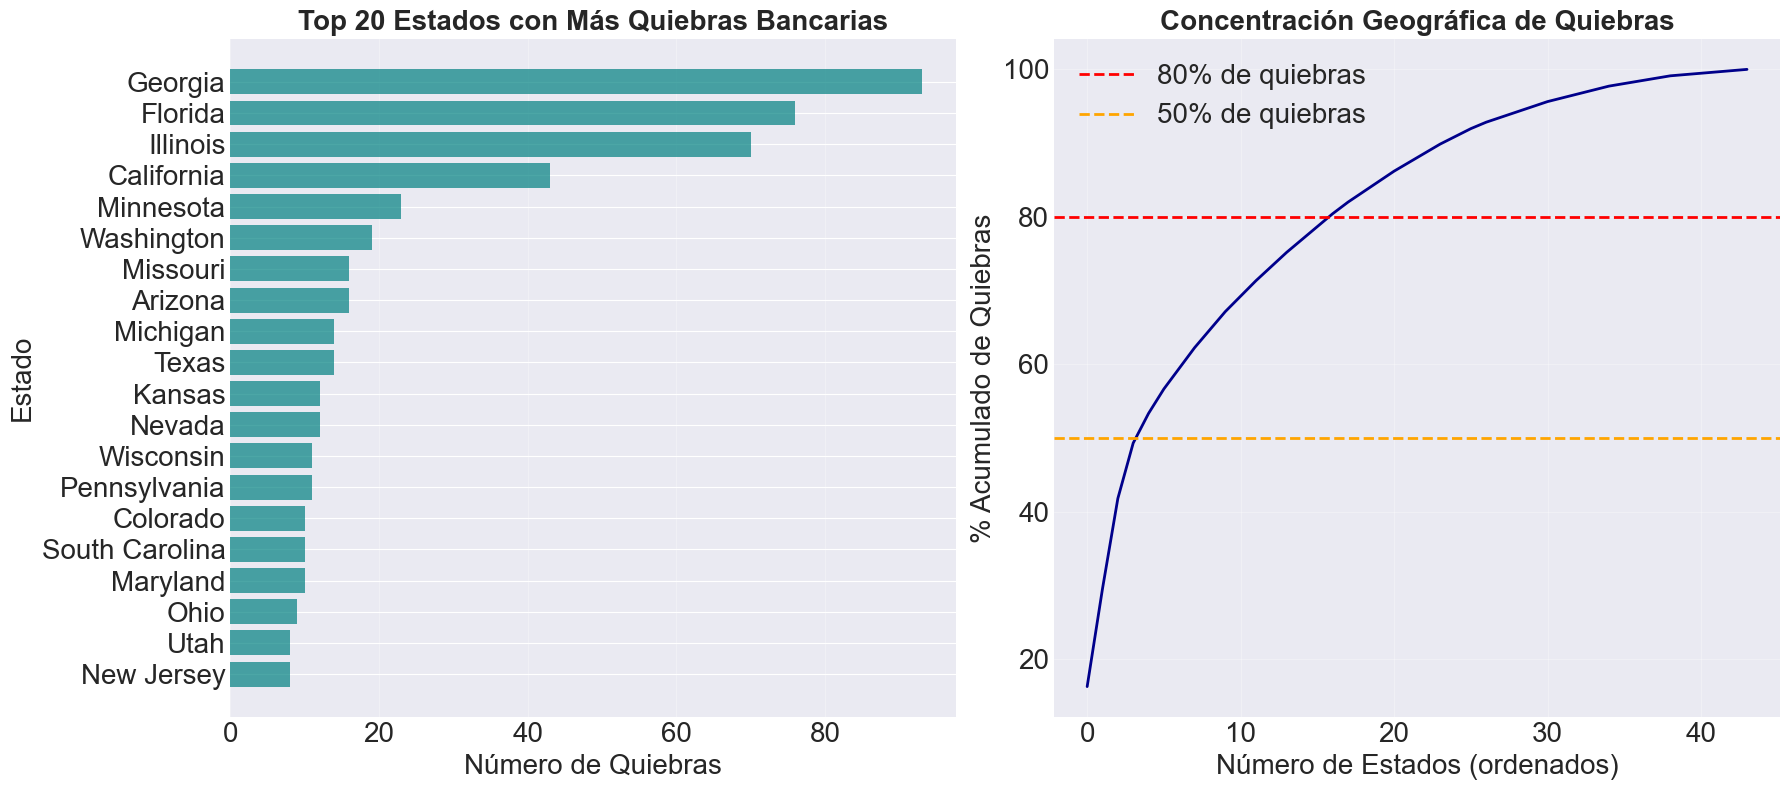


16 estados concentran el 80% de las quiebras
Total de estados afectados: 44


In [140]:
# Identificar columna de estado
state_columns = [col for col in fdic_failed.columns if 'state' in col.lower() or 'st' == col.lower()]
print(f"Columnas de estado detectadas: {state_columns}")

# Diccionario de mapeo de abreviaturas a nombres completos de estados
state_names = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'DC': 'District of Columbia', 'PR': 'Puerto Rico'
}

if len(state_columns) > 0:
    state_col = state_columns[0]
    
    # Mapear abreviaturas a nombres completos
    fdic_failed['state_full_name'] = fdic_failed[state_col].map(state_names).fillna(fdic_failed[state_col])
    
    # Análisis por estado
    state_dist = fdic_failed['state_full_name'].value_counts()
    
    print(f"\nEstados con más quiebras bancarias:")
    print(state_dist.head(15))
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Top 20 estados
    top_states = state_dist.head(20)
    axes[0].barh(top_states.index[::-1], top_states.values[::-1], color='teal', alpha=0.7)
    axes[0].set_xlabel('Número de Quiebras', fontsize=20)
    axes[0].set_ylabel('Estado', fontsize=20)
    axes[0].set_title('Top 20 Estados con Más Quiebras Bancarias', fontsize=20, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].tick_params(labelsize=20)
    
    # Distribución acumulada
    cumulative_pct = (state_dist.cumsum() / state_dist.sum() * 100)
    axes[1].plot(range(len(cumulative_pct)), cumulative_pct.values, linewidth=2, color='darkblue')
    axes[1].axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% de quiebras')
    axes[1].axhline(y=50, color='orange', linestyle='--', linewidth=2, label='50% de quiebras')
    axes[1].set_xlabel('Número de Estados (ordenados)', fontsize=20)
    axes[1].set_ylabel('% Acumulado de Quiebras', fontsize=20)
    axes[1].set_title('Concentración Geográfica de Quiebras', fontsize=20, fontweight='bold')
    axes[1].legend(fontsize=20)
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(labelsize=20)
    
    plt.tight_layout()
    plt.show()
    
    # Calcular concentración
    states_80pct = (cumulative_pct <= 80).sum()
    print(f"\n{states_80pct} estados concentran el 80% de las quiebras")
    print(f"Total de estados afectados: {len(state_dist)}")

## 4. Carga y Análisis de Datos FFIEC (Call Reports)

Los Call Reports contienen información financiera detallada de las instituciones bancarias. Cargaremos los schedules más relevantes para el análisis de supervivencia.

In [141]:
# Directorio de datos FFIEC
ffiec_dir = "FFIEC CDR Call Bulk All Schedules 03312001"

# Verificar archivos disponibles
if os.path.exists(ffiec_dir):
    files = os.listdir(ffiec_dir)
    print(f"Archivos FFIEC encontrados: {len(files)}")
    print("\nSchedules principales disponibles:")
    
    key_schedules = {
        'RC': 'Balance Sheet (Consolidated)',
        'RI': 'Income Statement',
        'RCA': 'Cash and Balances',
        'RCB': 'Securities',
        'RCC': 'Loans and Leases',
        'RCD': 'Trading Assets and Liabilities',
        'RCE': 'Deposit Liabilities',
        'RCG': 'Other Assets',
        'RCL': 'Derivatives and Off-Balance Sheet',
        'RCM': 'Memoranda',
        'ENT': 'Entity Information'
    }
    
    available_schedules = []
    for schedule, description in key_schedules.items():
        matching = [f for f in files if schedule in f and f.endswith('.txt')]
        if matching:
            available_schedules.append((schedule, description, matching[0]))
            print(f"   ✓ {schedule}: {description}")
    
    print(f"\n✓ Total de schedules clave encontrados: {len(available_schedules)}")
else:
    print(f"Directorio {ffiec_dir} no encontrado")

Archivos FFIEC encontrados: 35

Schedules principales disponibles:
   ✓ RC: Balance Sheet (Consolidated)
   ✓ RI: Income Statement
   ✓ RCA: Cash and Balances
   ✓ RCB: Securities
   ✓ RCC: Loans and Leases
   ✓ RCD: Trading Assets and Liabilities
   ✓ RCE: Deposit Liabilities
   ✓ RCG: Other Assets
   ✓ RCL: Derivatives and Off-Balance Sheet
   ✓ RCM: Memoranda
   ✓ ENT: Entity Information

✓ Total de schedules clave encontrados: 11


In [142]:
# Función para cargar archivos FFIEC (formato delimitado por tabs)
def load_ffiec_schedule(filename, columns=None, drop_description=True):
    """
    Carga un archivo FFIEC Call Report y devuelve las columnas solicitadas.
    Si se proporciona `columns`, solo se extraen esas columnas (manteniendo IDRSSD).
    """
    filepath = os.path.join(ffiec_dir, filename)
    try:
        with open(filepath, encoding='utf-8', newline='') as f:
            reader = csv.reader(f, delimiter='	')
            raw_header = next(reader)
            header = [col.strip('"').strip() for col in raw_header]
            first_row = next(reader, [])
            if drop_description and (not first_row or not first_row[0].strip()):
                data_iter = reader
            else:
                data_iter = itertools.chain([first_row], reader)
            if columns:
                requested = []
                for col in columns:
                    col_name = col.strip('"').strip()
                    if col_name in header and col_name not in requested:
                        requested.append(col_name)
                if 'IDRSSD' not in requested and 'IDRSSD' in header:
                    requested.insert(0, 'IDRSSD')
                indices = {col: header.index(col) for col in requested}
                data = {col: [] for col in requested}
                for row in data_iter:
                    if not any(row):
                        continue
                    for col, idx in indices.items():
                        value = row[idx] if idx < len(row) else ''
                        data[col].append(value.strip())
                df = pd.DataFrame(data)
            else:
                rows = [row for row in data_iter if any(row)]
                df = pd.DataFrame(rows, columns=header)
            df = df.loc[:, [col for col in df.columns if col]]
            if 'IDRSSD' in df.columns:
                df['IDRSSD'] = df['IDRSSD'].astype(str).str.strip()
            return df
    except FileNotFoundError:
        print(f"Archivo {filename} no encontrado en {ffiec_dir}")
    except Exception as e:
        print(f"Error cargando {filename}: {e}")
    return None


In [143]:
# Cargar los schedules más importantes para análisis de solvencia
print("\nCargando Schedules principales...")
print("=" * 80)

rc_file = next((f for f in files if "Schedule RC " in f and f.endswith("03312001.txt")), None)
ent_file = next((f for f in files if "Schedule ENT" in f and f.endswith(".txt")), None)
por_file = next((f for f in files if "FFIEC CDR Call Bulk POR" in f and f.endswith(".txt")), None)

rc_columns = [
    "IDRSSD",
    "RCFD2170", "RCON2170",
    "RCFD2200", "RCON2200",
    "RCFD3210", "RCON3210",
    "RCFD2948", "RCON2948",
    "RCFD3123", "RCON3123",
    "RCFD3190", "RCON3190"
]

df_rc = load_ffiec_schedule(rc_file, columns=rc_columns) if rc_file else None
if df_rc is not None:
    print(f"✓ {rc_file}: {len(df_rc):,} registros, {len(df_rc.columns)} columnas seleccionadas")
else:
    print("⚠️ No fue posible cargar Schedule RC")

df_ent = load_ffiec_schedule(ent_file, drop_description=False) if ent_file else None
if df_ent is not None:
    df_ent = df_ent.loc[:, ~df_ent.columns.str.fullmatch('')]
    print(f"✓ {ent_file}: {len(df_ent):,} registros, {len(df_ent.columns)} columnas")
else:
    print("⚠️ No fue posible cargar Schedule ENT")

df_por = load_ffiec_schedule(por_file, drop_description=False) if por_file else None
if df_por is not None:
    df_por = df_por.rename(columns={"FDIC Certificate Number": "Cert"})
    df_por['IDRSSD'] = df_por['IDRSSD'].astype(str).str.strip()
    df_por['Cert'] = df_por['Cert'].astype(str).str.strip()
    print(f"✓ {por_file}: {len(df_por):,} registros con Certificate Number")
else:
    print("⚠️ No fue posible cargar Schedule POR (Certificate Number)")


Cargando Schedules principales...
✓ FFIEC CDR Call Schedule RC 03312001.txt: 8,857 registros, 12 columnas seleccionadas
✓ FFIEC CDR Call Schedule ENT 03312001.txt: 8,858 registros, 8 columnas
✓ FFIEC CDR Call Bulk POR 03312001.txt: 8,857 registros con Certificate Number


In [ ]:
# DIAGNÓSTICO: Explorar columnas reales del Schedule RC
if df_rc is not None:
    print("\n" + "=" * 80)
    print("DIAGNÓSTICO DE COLUMNAS EN SCHEDULE RC")
    print("=" * 80)
    
    print(f"\n📊 Información del DataFrame cargado:")
    print(f"   Filas: {len(df_rc):,}")
    print(f"   Columnas: {len(df_rc.columns)}")
    
    print(f"\n📋 Columnas solicitadas:")
    for col in rc_columns:
        print(f"   • {col}")
    
    print(f"\n✅ Columnas realmente presentes en df_rc:")
    for col in df_rc.columns:
        print(f"   • {col}")
    
    # Verificar si las columnas tienen datos
    print(f"\n🔍 Verificando datos en cada columna:")
    for col in df_rc.columns:
        non_null = df_rc[col].notna().sum()
        pct = (non_null / len(df_rc) * 100) if len(df_rc) > 0 else 0
        sample_val = df_rc[col].dropna().iloc[0] if non_null > 0 else "N/A"
        print(f"   {col}: {non_null:,} valores ({pct:.1f}%) - Ejemplo: {sample_val}")
    
    # Mostrar primeras filas para ver los datos
    print("\n📊 Primeras 3 filas del Schedule RC:")
    display(df_rc.head(3))
    
    # Intentar cargar el archivo completo sin filtrar columnas
    print("\n🔧 Intentando cargar TODAS las columnas del archivo...")
    df_rc_full = load_ffiec_schedule(rc_file, columns=None, drop_description=True)
    if df_rc_full is not None:
        print(f"   Total de columnas en archivo completo: {len(df_rc_full.columns)}")
        print(f"   Primeras 10 columnas: {df_rc_full.columns[:10].tolist()}")
        
        # Buscar las columnas que necesitamos
        print(f"\n? Buscando columnas financieras en el archivo completo:")
        target_codes = ['RCFD2170', 'RCON2170', 'RCFD3210', 'RCON3210', 'RCFD2948', 'RCON2948']
        for code in target_codes:
            if code in df_rc_full.columns:
                non_null = df_rc_full[code].notna().sum()
                print(f"   ✅ {code}: ENCONTRADA ({non_null:,} valores)")
            else:
                print(f"   ❌ {code}: NO ENCONTRADA")
else:
    print("⚠️ df_rc es None - no se cargó el Schedule RC")

: 

In [145]:
# Explorar Schedule ENT (Entity Information)
print("\n" + "=" * 80)
print("SCHEDULE ENT - ENTITY INFORMATION")
print("=" * 80)

if df_ent is not None:
    print(f"\nDimensiones: {df_ent.shape}")
    print(f"\nColumnas disponibles:")
    print(df_ent.columns.tolist())
    
    # Buscar columna Certificate Number
    cert_cols = [col for col in df_ent.columns if 'CERT' in col.upper() or 'CERTIFICATE' in col.upper()]
    print(f"\nColumnas de Certificate encontradas: {cert_cols}")
    
    print("\n📝 Nota: El Certificate Number se obtiene del Schedule POR (FDIC Certificate Number)")
    print("   y se usa como clave de unión con la lista de bancos quebrados de FDIC.")

    print("\nPrimeros registros:")
    display(df_ent.head(10))


SCHEDULE ENT - ENTITY INFORMATION

Dimensiones: (8858, 8)

Columnas disponibles:
['IDRSSD', 'RCON9999', 'RSSD9017', 'RSSD9050', 'RSSD9130', 'RSSD9200', 'RSSD9220', 'TEXT4087']

Columnas de Certificate encontradas: []

📝 Nota: El Certificate Number se obtiene del Schedule POR (FDIC Certificate Number)
   y se usa como clave de unión con la lista de bancos quebrados de FDIC.

Primeros registros:


,IDRSSD,RCON9999,RSSD9017,RSSD9050,RSSD9130,RSSD9200,RSSD9220,TEXT4087
0,,MICR9999REPORT DATE,LEGAL NAME,CERTIFICATE NUMBER,CITY NAME,STATE ABBREVIATION,ZIP CODE,PRIMARY INTERNET WEB ADDRESS
1,37,20010331,,,,,,
2,242,20010331,,,,,,
3,279,20010331,,,,,,
4,354,20010331,,,,,,
5,439,20010331,,,,,,
6,457,20010331,,,,,,
7,505,20010331,,,,,,
8,1146,20010331,,,,,,
9,1155,20010331,,,,,,


## 5. Indicadores Financieros Clave (Ratios)

Calcularemos los principales indicadores de salud financiera bancaria que son predictores de quiebra:

### Ratios de Capital (Solvencia)
- **Capital Ratio**: Capital Total / Activos Totales
- **Equity to Assets**: Equity / Total Assets
- **Tier 1 Capital Ratio**: Tier 1 Capital / Risk-Weighted Assets

### Ratios de Liquidez
- **Loan to Deposit Ratio**: Préstamos / Depósitos
- **Cash to Assets**: Efectivo / Activos Totales

### Ratios de Calidad de Activos
- **Non-Performing Loans Ratio**: NPL / Total Loans
- **Allowance to Loans**: Reservas / Préstamos Totales

### Ratios de Rentabilidad
- **ROA (Return on Assets)**: Ingreso Neto / Activos Totales
- **ROE (Return on Equity)**: Ingreso Neto / Equity
- **Net Interest Margin**: (Ingresos por Intereses - Gastos por Intereses) / Activos

In [146]:
# Identificar las columnas clave del Balance Sheet (Schedule RC)
balance_sheet_map = {
    "total_assets": {"label": "Total Assets", "codes": ["RCFD2170", "RCON2170"]},
    "total_deposits": {"label": "Total Deposits", "codes": ["RCFD2200", "RCON2200"]},
    "total_equity": {"label": "Total Equity Capital", "codes": ["RCFD3210", "RCON3210"]},
    "loans_net": {"label": "Loans & Leases Net", "codes": ["RCFD2948", "RCON2948"]},
    "allowance": {"label": "Allowance for Loan & Lease Losses", "codes": ["RCFD3123", "RCON3123"]},
    "total_liabilities": {"label": "Total Liabilities", "codes": ["RCFD3190", "RCON3190"]}
}

if df_rc is not None:
    print("Identificando variables clave del Balance Sheet con respaldo RCFD/RCON...")
    available = []
    missing = []
    for alias, meta in balance_sheet_map.items():
        found = next((code for code in meta["codes"] if code in df_rc.columns), None)
        if found:
            available.append((meta["label"], found))
        else:
            missing.append(meta["label"])
    print(f"✓ Variables con datos disponibles: {len(available)}/{len(balance_sheet_map)}")
    for label, code in available:
        print(f"   {label}: {code}")
    if missing:
        print("Variables sin datos en este corte:")
        for label in missing:
            print(f"   - {label}")
else:
    print(" Schedule RC no cargado; no se puede identificar variables financieras.")


Identificando variables clave del Balance Sheet con respaldo RCFD/RCON...
✓ Variables con datos disponibles: 6/6
   Total Assets: RCFD2170
   Total Deposits: RCON2200
   Total Equity Capital: RCFD3210
   Loans & Leases Net: RCFD2948
   Allowance for Loan & Lease Losses: RCFD3123
   Total Liabilities: RCFD3190


In [147]:
# Calcular ratios financieros
def select_numeric_series(df, codes):
    for code in codes:
        if code in df.columns:
            series = pd.to_numeric(df[code], errors='coerce')
            if series.notna().any():
                return series
    return pd.Series(pd.NA, index=df.index, dtype='float64')

def safe_ratio(numerator, denominator):
    result = numerator / denominator
    return result.where(denominator.notna() & (denominator != 0))

if df_rc is not None:
    df_rc_ratios = pd.DataFrame({"IDRSSD": df_rc["IDRSSD"]})
    for alias, meta in balance_sheet_map.items():
        df_rc_ratios[alias] = select_numeric_series(df_rc, meta["codes"])

    df_rc_ratios["equity_to_assets"] = safe_ratio(df_rc_ratios["total_equity"], df_rc_ratios["total_assets"])
    df_rc_ratios["loan_to_deposit"] = safe_ratio(df_rc_ratios["loans_net"], df_rc_ratios["total_deposits"])
    df_rc_ratios["allowance_to_loans"] = safe_ratio(df_rc_ratios["allowance"], df_rc_ratios["loans_net"])
    df_rc_ratios["deposits_to_assets"] = safe_ratio(df_rc_ratios["total_deposits"], df_rc_ratios["total_assets"])
    df_rc_ratios["debt_to_equity"] = safe_ratio(df_rc_ratios["total_liabilities"], df_rc_ratios["total_equity"])

    ratio_columns = ["equity_to_assets", "loan_to_deposit", "allowance_to_loans", "deposits_to_assets", "debt_to_equity"]
    existing_ratios = [col for col in ratio_columns if col in df_rc_ratios.columns]

    print(f" ✓ Ratios calculados: {len(existing_ratios)}")
    coverage = (df_rc_ratios[existing_ratios].notna().sum() / len(df_rc_ratios) * 100).round(1)
    print("Cobertura de datos (% de instituciones con valor):")
    for ratio in existing_ratios:
        print(f"   {ratio}: {coverage[ratio]:.1f}%")

    display(df_rc_ratios[existing_ratios].describe())
else:
    print("⚠️ No se pudo calcular ratios por falta de datos del Schedule RC.")
    df_rc_ratios = None
    existing_ratios = []


 ✓ Ratios calculados: 5
Cobertura de datos (% de instituciones con valor):
   equity_to_assets: 1.7%
   loan_to_deposit: 1.7%
   allowance_to_loans: 1.7%
   deposits_to_assets: 1.7%
   debt_to_equity: 1.7%


,equity_to_assets,loan_to_deposit,allowance_to_loans,deposits_to_assets,debt_to_equity
count,149.000000,147.000000,149.000000,149.000000,149.000000
mean,0.107003,2.317492,0.012288,0.607242,0.813129
std,0.079359,4.525897,0.010472,0.220537,0.916983
min,0.051333,1.013345,0.000000,0.000000,0.000000
25%,0.075370,1.183718,0.007697,0.521370,0.063564
50%,0.085189,1.358818,0.010677,0.667143,0.558139
75%,0.102282,1.686370,0.013446,0.768223,1.106617
max,0.765505,47.658234,0.098891,0.906122,5.080781


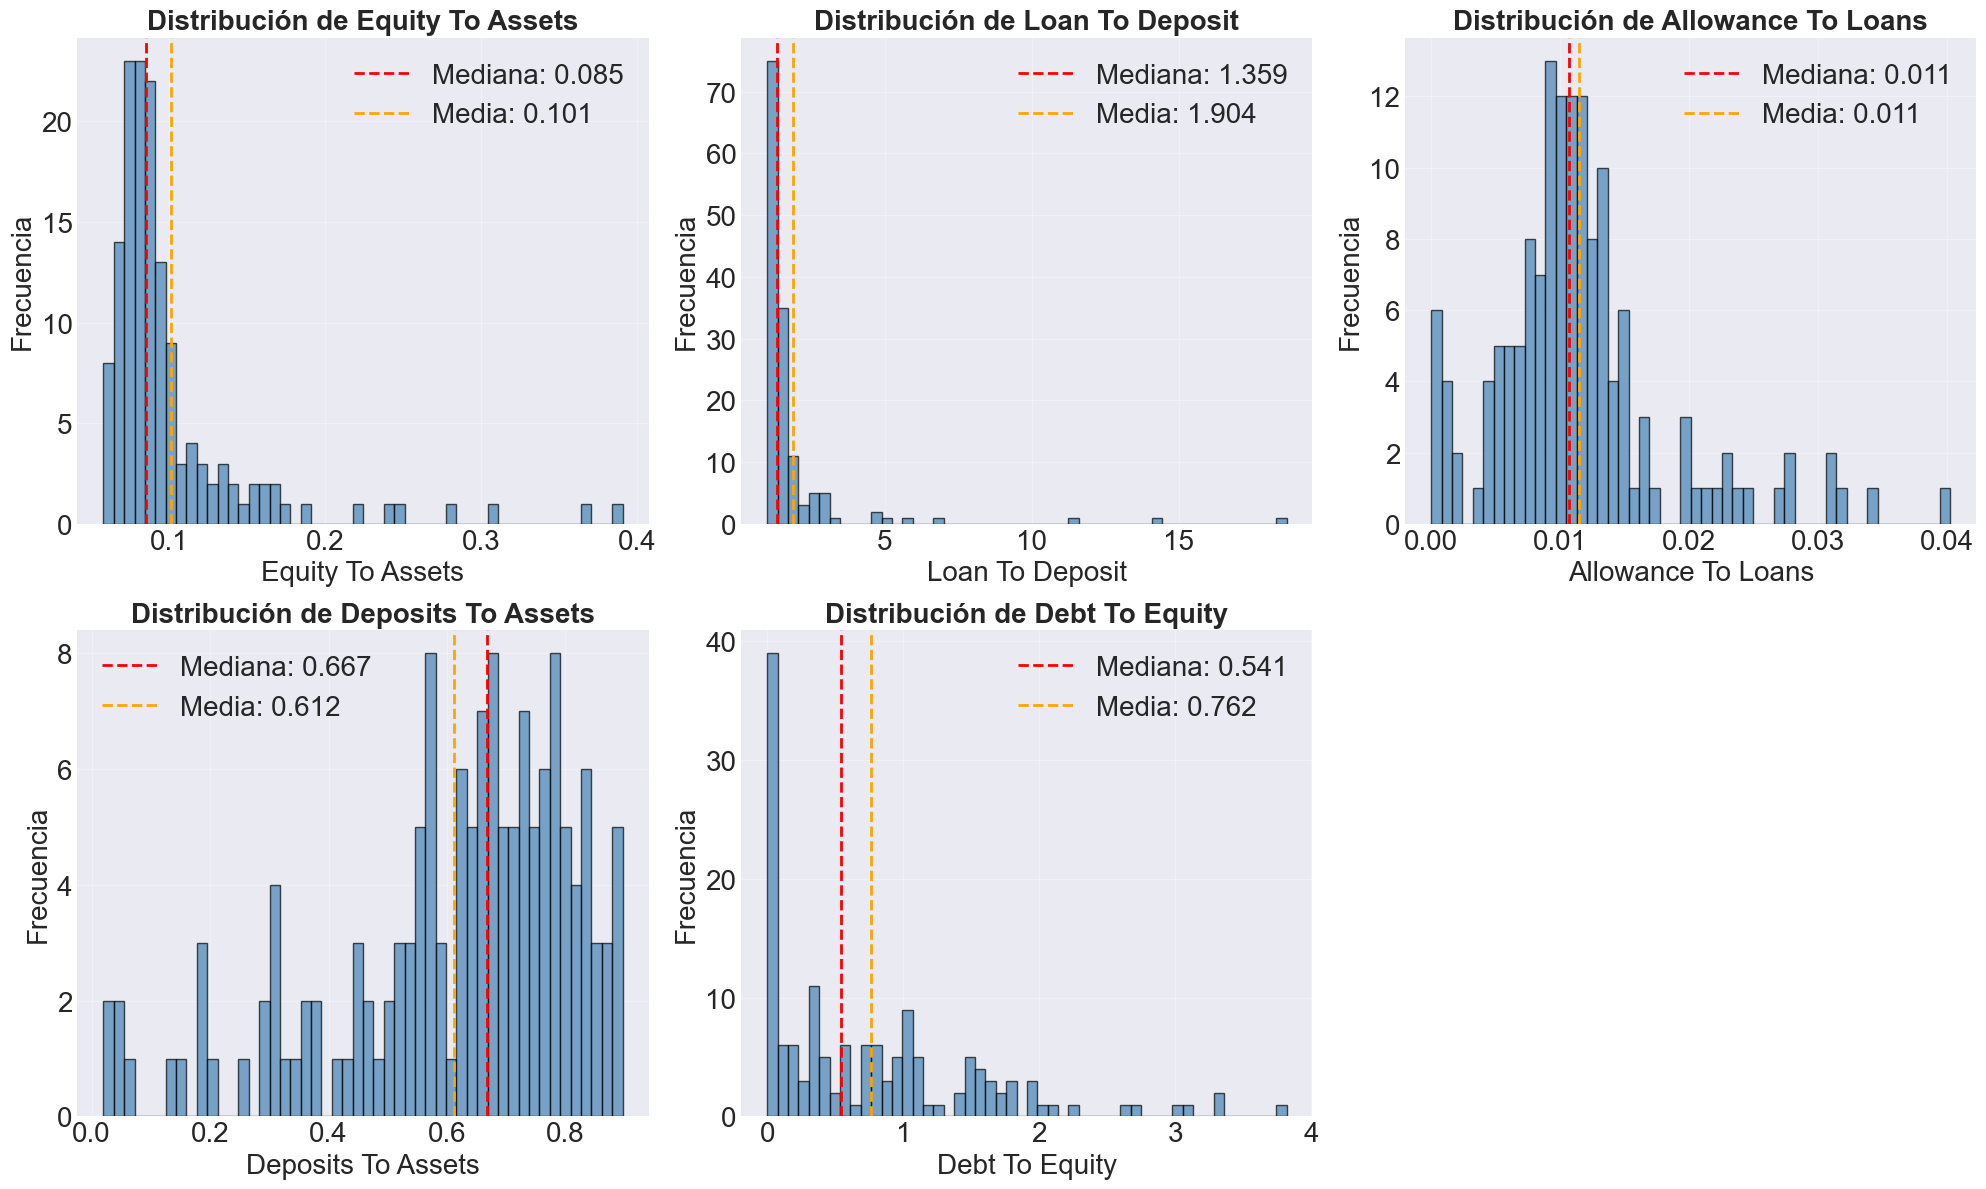

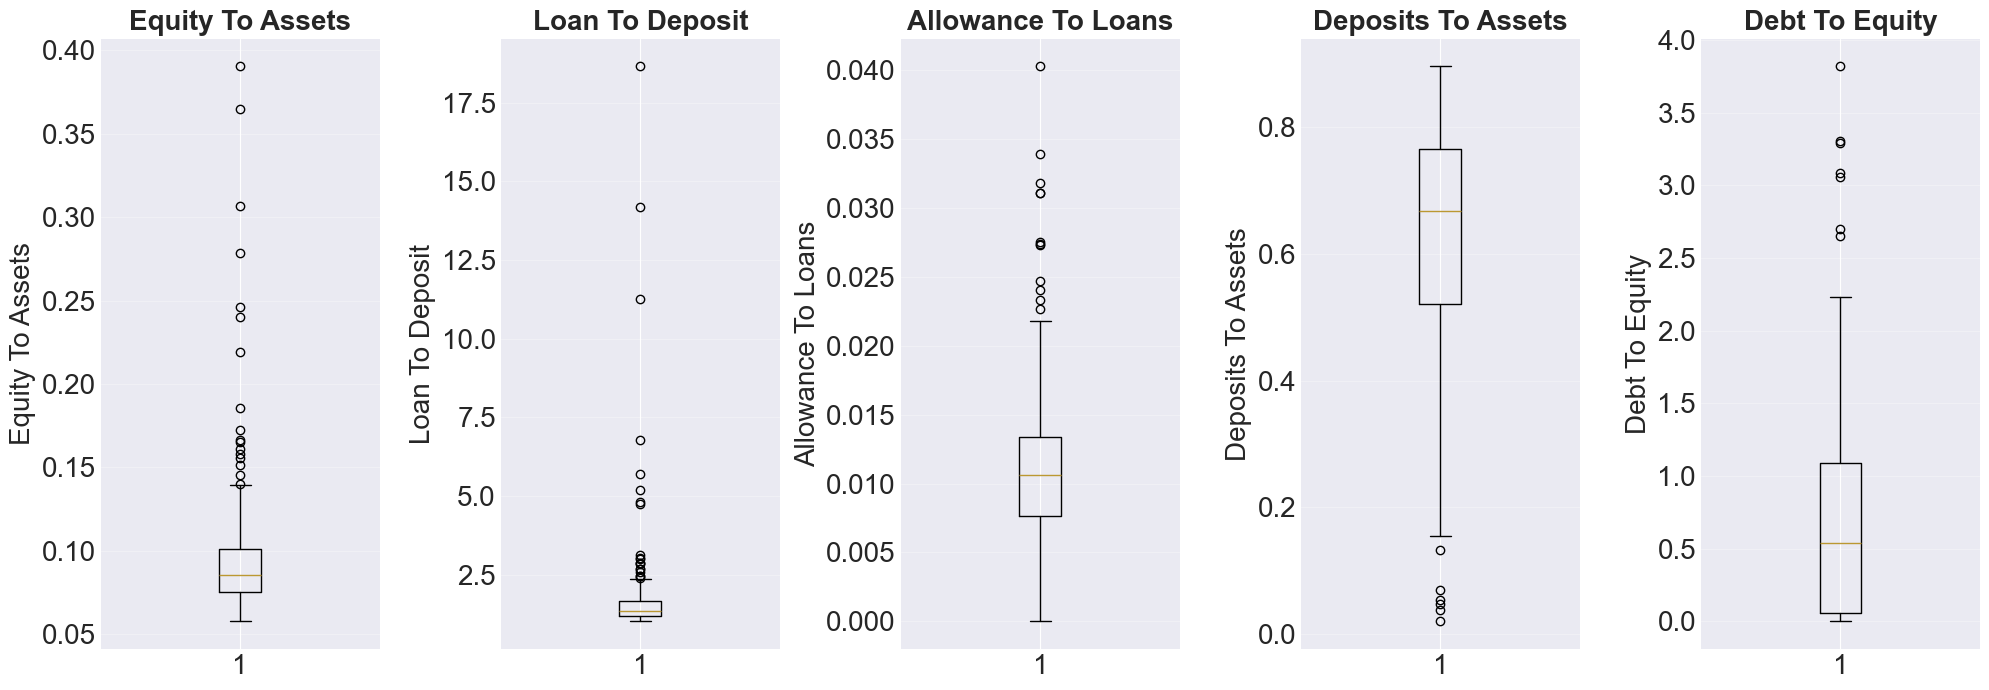

In [148]:
# Visualizar distribuciones de ratios
if existing_ratios:
    n_ratios = len(existing_ratios)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, ratio in enumerate(existing_ratios):
        # Filtrar valores extremos para mejor visualización
        data = df_rc_ratios[ratio].dropna()
        q1, q99 = data.quantile([0.01, 0.99])
        data_filtered = data[(data >= q1) & (data <= q99)]
        
        # Histograma
        axes[idx].hist(data_filtered, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[idx].axvline(data_filtered.median(), color='red', linestyle='--', 
                         linewidth=2, label=f'Mediana: {data_filtered.median():.3f}')
        axes[idx].axvline(data_filtered.mean(), color='orange', linestyle='--', 
                         linewidth=2, label=f'Media: {data_filtered.mean():.3f}')
        axes[idx].set_xlabel(ratio.replace('_', ' ').title(), fontsize=20)
        axes[idx].set_ylabel('Frecuencia', fontsize=20)
        axes[idx].set_title(f'Distribución de {ratio.replace("_", " ").title()}', 
                           fontsize=20, fontweight='bold')
        axes[idx].legend(fontsize=20)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(labelsize=20)
    
    # Ocultar ejes sobrantes
    for idx in range(n_ratios, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Boxplots
    fig, axes = plt.subplots(1, len(existing_ratios), figsize=(4*len(existing_ratios), 7))
    if len(existing_ratios) == 1:
        axes = [axes]
    
    for idx, ratio in enumerate(existing_ratios):
        data = df_rc_ratios[ratio].dropna()
        q1, q99 = data.quantile([0.01, 0.99])
        data_filtered = data[(data >= q1) & (data <= q99)]
        
        axes[idx].boxplot(data_filtered, vert=True)
        axes[idx].set_ylabel(ratio.replace('_', ' ').title(), fontsize=20)
        axes[idx].set_title(f'{ratio.replace("_", " ").title()}', fontsize=20, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='y')
        axes[idx].tick_params(labelsize=20)
    
    plt.tight_layout()
    plt.show()

## 5.1 Marco CAMELS: Enfoque de Selección de Características

### ¿Qué es CAMELS?

**CAMELS** es el sistema estándar utilizado por reguladores bancarios (FDIC, OCC, Federal Reserve) para evaluar la salud de las instituciones financieras. Cada banco es calificado del **1 al 5**, donde:
- **1** = Fuerte (bajo riesgo)
- **5** = Crítico (alto riesgo de quiebra)

### Los 6 Componentes CAMELS:

1. **C - Capital Adequacy** (Adecuación de Capital)
   - Capacidad del capital para absorber pérdidas
   - Ratios: Equity/Assets, Tier 1 Capital, Leverage Ratio

2. **A - Asset Quality** (Calidad de Activos)
   - Riesgo de la cartera de préstamos e inversiones
   - Ratios: NPL/Total Loans, Allowance/Loans, Charge-offs

3. **M - Management Quality** (Calidad de Gestión)
   - Capacidad administrativa para manejar riesgos
   - Difícil de cuantificar (evaluación cualitativa)

4. **E - Earnings** (Rentabilidad)
   - Sostenibilidad y calidad de utilidades
   - Ratios: ROA, ROE, Net Interest Margin, Efficiency Ratio

5. **L - Liquidity** (Liquidez)
   - Capacidad de cumplir obligaciones a corto plazo
   - Ratios: Loan/Deposit, Liquid Assets/Assets, Core Deposits/Assets

6. **S - Sensitivity to Market Risk** (Sensibilidad a Riesgo de Mercado)
   - Vulnerabilidad a tasas de interés, tipos de cambio
   - Ratios: Duration Gap, Interest Rate Risk exposure


### Nuestra Estrategia:

Calcularemos ratios representativos de cada componente CAMELS donde los datos estén disponibles, priorizando:
- **Variables cuantitativas** del Balance Sheet (RC) e Income Statement (RI)
- **Ratios estandarizados** usados por reguladores
- **Métricas con alto poder discriminatorio** entre bancos quebrados y solventes

## 6. Unión de Datasets: FDIC + FFIEC mediante Certificate Number

Usamos el Schedule POR para recuperar el *Certificate Number* reportado por cada institución y así enlazar los estados financieros del FFIEC con la lista de bancos quebrados de la FDIC.


In [149]:
# Preparar mapa de certificados desde Schedule POR
df_cert_map = None
if df_por is not None:
    print("Resumen de certificados disponibles en Schedule POR:")
    df_cert_map = df_por[["IDRSSD", "Cert"]].copy()
    df_cert_map["IDRSSD"] = df_cert_map["IDRSSD"].astype(str).str.strip()
    df_cert_map["Cert"] = df_cert_map["Cert"].astype(str).str.strip()
    coverage = df_cert_map["Cert"].notna().mean() * 100
    print(f"   Certificados disponibles para {df_cert_map['Cert'].notna().sum():,} de {len(df_cert_map):,} instituciones ({coverage:.1f}%)")
else:
    print("⚠️ No se encontró Schedule POR; no habrá Cert para la unión con FDIC.")


Resumen de certificados disponibles en Schedule POR:
   Certificados disponibles para 8,857 de 8,857 instituciones (100.0%)


In [150]:
# Unir FFIEC Entity con Balance Sheet usando IDRSSD
df_ffiec = None
if df_ent is not None and df_rc_ratios is not None:
    print("Uniendo datos FFIEC (Entity + Balance Sheet + Certificate Number)...")
    df_ent_clean = df_ent.copy()
    df_ent_clean["IDRSSD"] = df_ent_clean["IDRSSD"].astype(str).str.strip()
    df_ffiec = df_ent_clean.merge(df_rc_ratios, on="IDRSSD", how="inner")
    if df_cert_map is not None:
        df_ffiec = df_ffiec.merge(df_cert_map, on="IDRSSD", how="left")
    print(f"✓ Dataset FFIEC unificado: {df_ffiec.shape}")
    print(f"   Instituciones con datos financieros: {df_ffiec['IDRSSD'].nunique():,}")
    if "Cert" in df_ffiec.columns:
        missing = df_ffiec['Cert'].isna().sum()
        print(f"   Certificados faltantes: {missing:,} ({missing/len(df_ffiec)*100:.1f}%)")
else:
    print("No se pudo crear el dataset FFIEC unificado (faltan componentes).")


Uniendo datos FFIEC (Entity + Balance Sheet + Certificate Number)...
✓ Dataset FFIEC unificado: (8857, 20)
   Instituciones con datos financieros: 8,857
   Certificados faltantes: 0 (0.0%)


In [151]:
# Crear variable target: etiquetar bancos quebrados
if df_ffiec is not None and "Cert" in df_ffiec.columns:
    print("Creando variable target (Failed/Not Failed)...")
    fdic_failed["Cert"] = fdic_failed["Cert"].astype(str).str.strip()
    df_ffiec["Cert"] = df_ffiec["Cert"].astype(str).str.strip()
    df_ffiec["FAILED"] = df_ffiec["Cert"].isin(fdic_failed["Cert"]).astype(int)

    n_total = len(df_ffiec)
    n_failed = df_ffiec["FAILED"].sum()
    print(f"   Total de instituciones: {n_total:,}")
    print(f"   Bancos quebrados (FAILED=1): {n_failed:,} ({n_failed/n_total*100:.2f}%)")
    print(f"   Bancos solventes (FAILED=0): {n_total - n_failed:,} ({(n_total - n_failed)/n_total*100:.2f}%)")
else:
    print("No se pudo crear variable target: Certificado FDIC ausente en el dataset unificado.")


Creando variable target (Failed/Not Failed)...
   Total de instituciones: 8,857
   Bancos quebrados (FAILED=1): 377 (4.26%)
   Bancos solventes (FAILED=0): 8,480 (95.74%)


In [152]:
df_ffiec.head()

,IDRSSD,RCON9999,RSSD9017,RSSD9050,RSSD9130,RSSD9200,RSSD9220,TEXT4087,total_assets,total_deposits,total_equity,loans_net,allowance,total_liabilities,equity_to_assets,loan_to_deposit,allowance_to_loans,deposits_to_assets,debt_to_equity,Cert,FAILED
0,37,20010331,,,,,,,NaN,53715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10057,0
1,242,20010331,,,,,,,NaN,18853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3850,0
2,279,20010331,,,,,,,NaN,71424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28868,0
3,354,20010331,,,,,,,NaN,6912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14083,0
4,439,20010331,,,,,,,NaN,140569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16498,0


**Cómo el dataset está desbalanceado debemos de integrar técnicas de balanceo como SMOTE, undersampling, y evaluarlo con métricas como F1 weighted**

## 7. Análisis Comparativo: Bancos Quebrados vs. Solventes

In [153]:
# Comparar ratios financieros entre bancos quebrados y solventes
if 'FAILED' in df_ffiec.columns and existing_ratios:
    print("Comparación de Ratios Financieros: Quebrados vs. Solventes")
    print("=" * 80)
    
    failed_banks = df_ffiec[df_ffiec['FAILED'] == 1]
    solvent_banks = df_ffiec[df_ffiec['FAILED'] == 0]
    
    comparison_stats = []
    
    for ratio in existing_ratios:
        failed_data = failed_banks[ratio].dropna()
        solvent_data = solvent_banks[ratio].dropna()
        
        if len(failed_data) > 0 and len(solvent_data) > 0:
            stats = {
                'Ratio': ratio,
                'Failed_Mean': failed_data.mean(),
                'Solvent_Mean': solvent_data.mean(),
                'Failed_Median': failed_data.median(),
                'Solvent_Median': solvent_data.median(),
                'Failed_Std': failed_data.std(),
                'Solvent_Std': solvent_data.std(),
                'Difference_%': ((failed_data.mean() - solvent_data.mean()) / solvent_data.mean() * 100)
            }
            comparison_stats.append(stats)
    
    comparison_df = pd.DataFrame(comparison_stats)
    
    print("\nEstadísticas Comparativas:")
    display(comparison_df.round(4))

Comparación de Ratios Financieros: Quebrados vs. Solventes

Estadísticas Comparativas:


,Ratio,Failed_Mean,Solvent_Mean,Failed_Median,Solvent_Median,Failed_Std,Solvent_Std,Difference_%
0,equity_to_assets,0.0869,0.1081,0.0760,0.0856,0.0278,0.0812,-19.6307
1,loan_to_deposit,1.2516,2.3788,1.1972,1.3620,0.2073,4.6475,-47.3872
2,allowance_to_loans,0.0155,0.0121,0.0105,0.0107,0.0091,0.0105,28.2269
3,deposits_to_assets,0.7447,0.5994,0.7516,0.6638,0.1087,0.2229,24.2247
4,debt_to_equity,0.5496,0.8281,0.5179,0.5581,0.5660,0.9320,-33.6241


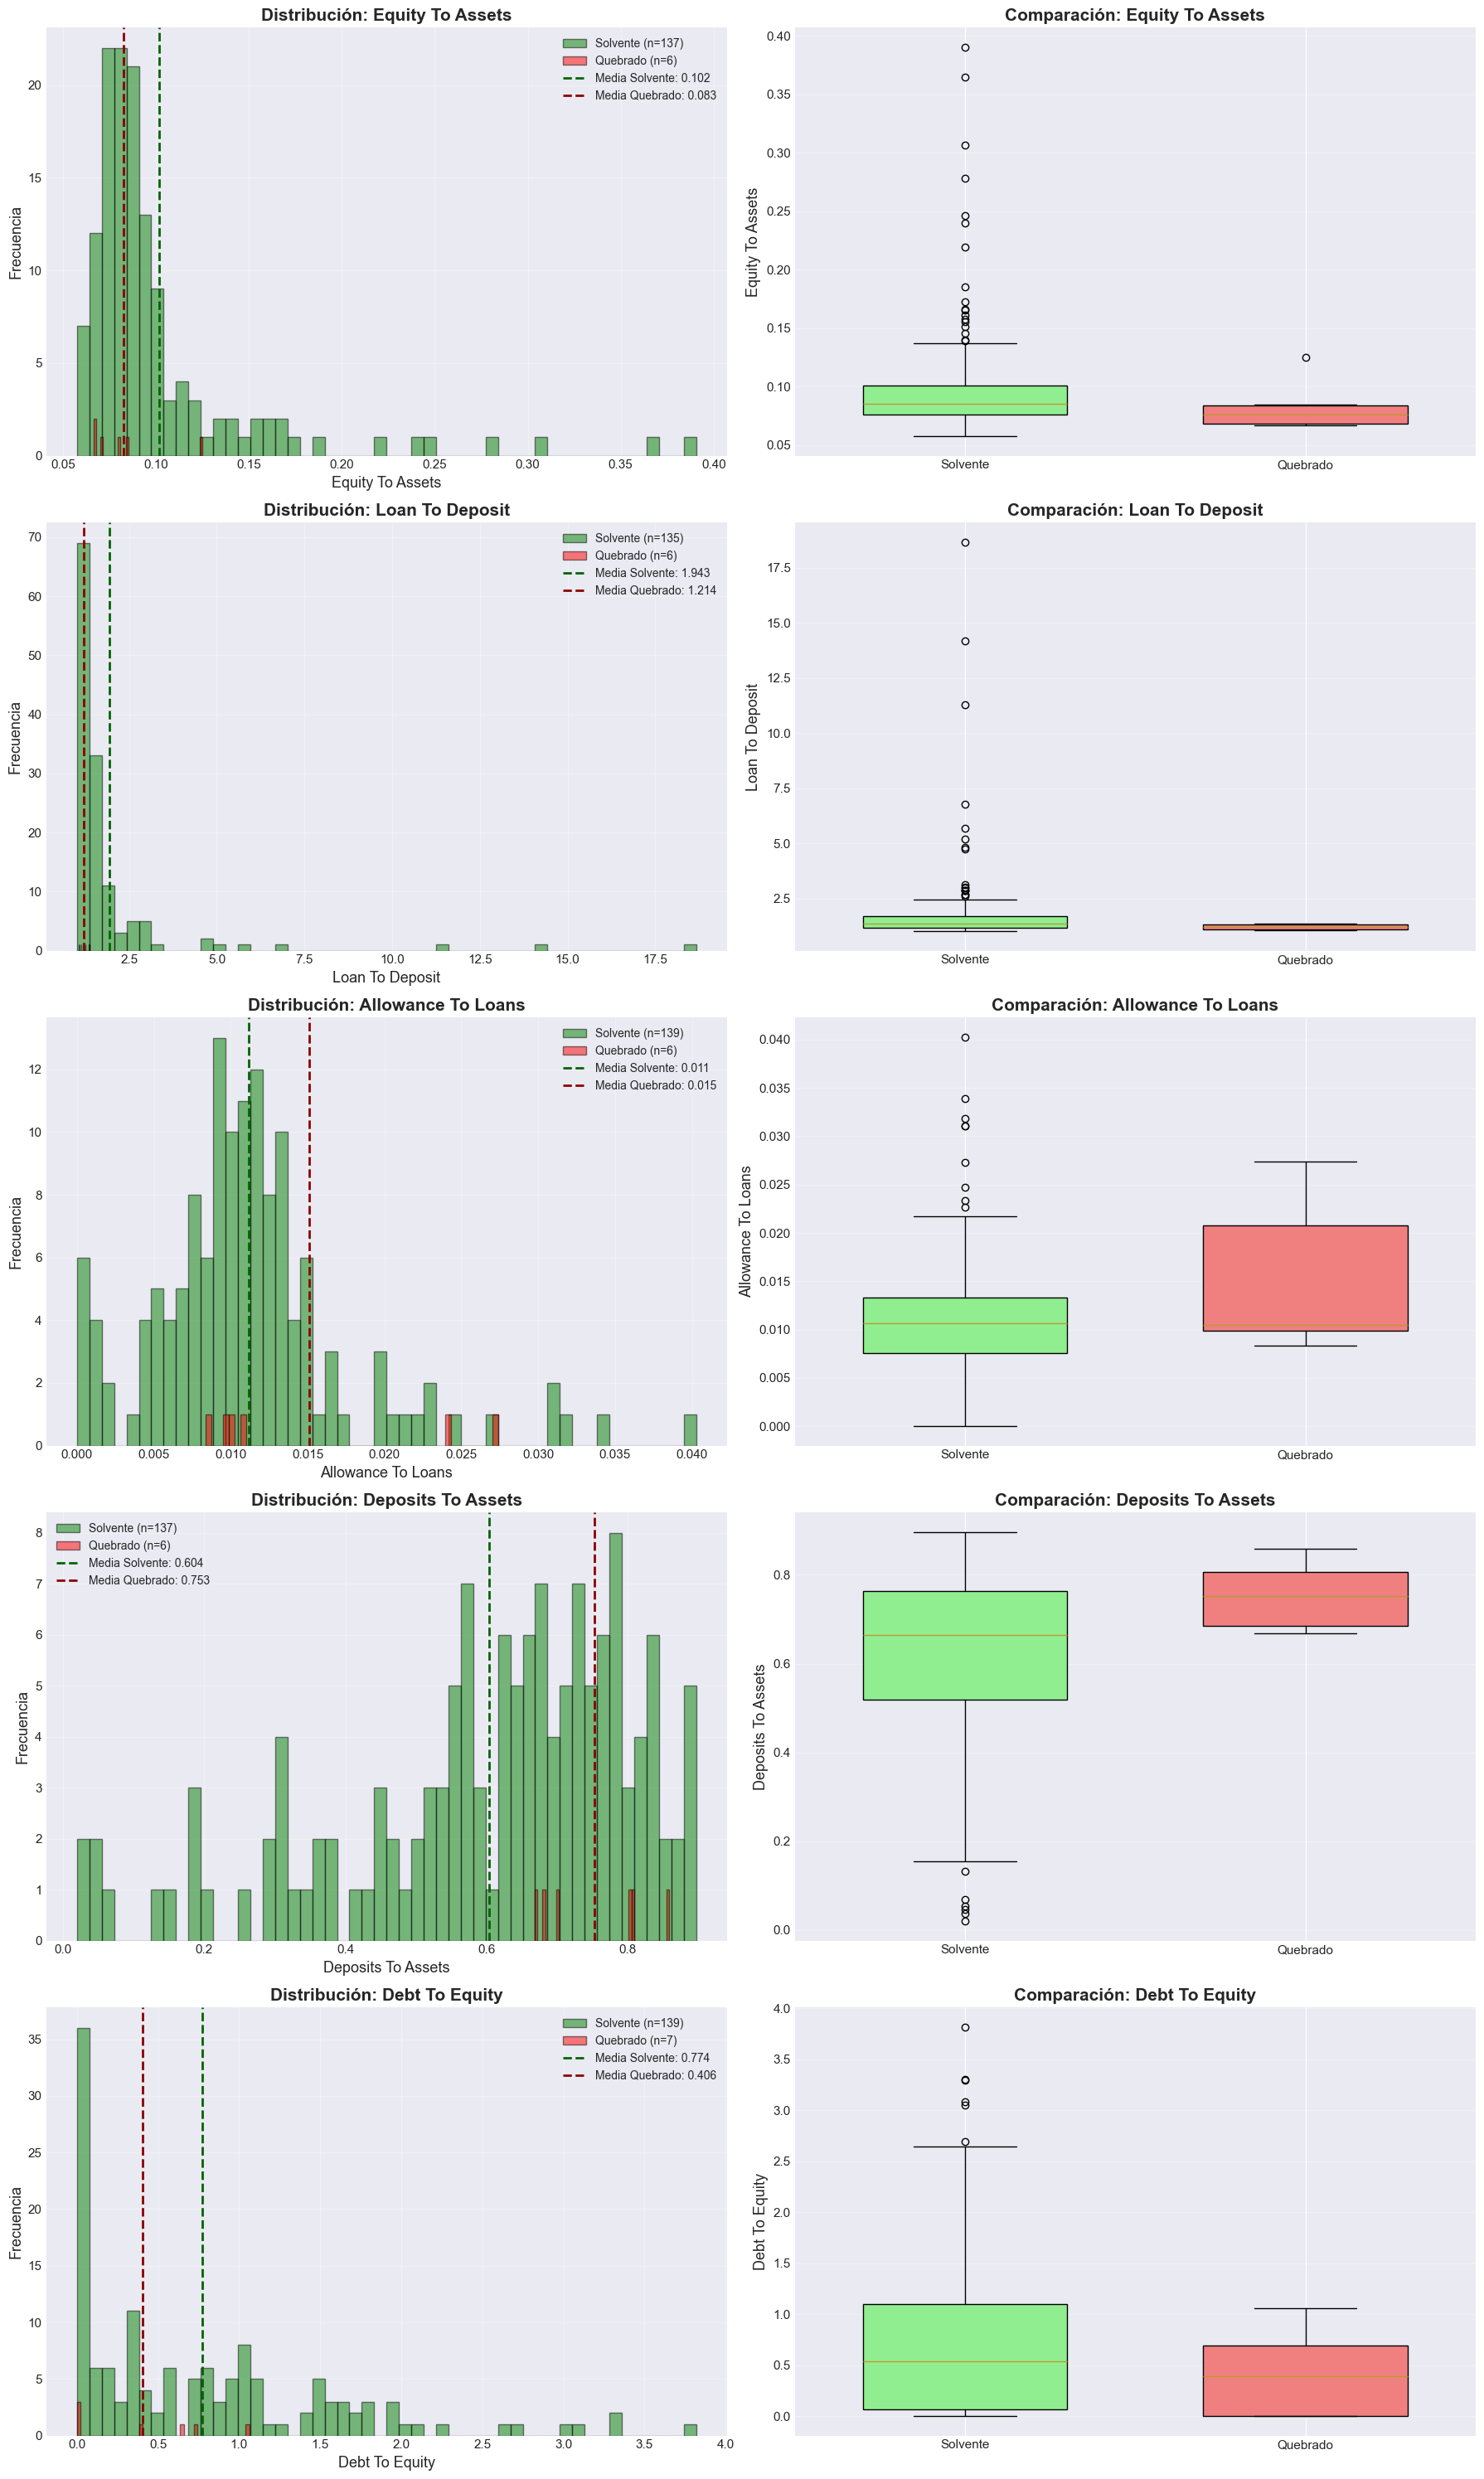

In [154]:
# Visualizar comparaciones
if 'FAILED' in df_ffiec.columns and existing_ratios:
    
    n_ratios = len(existing_ratios)
    fig, axes = plt.subplots(n_ratios, 2, figsize=(18, 6*n_ratios))
    
    if n_ratios == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ratio in enumerate(existing_ratios):
        failed_data = df_ffiec[df_ffiec['FAILED'] == 1][ratio].dropna()
        solvent_data = df_ffiec[df_ffiec['FAILED'] == 0][ratio].dropna()
        
        # Filtrar outliers para mejor visualización
        q1_f, q99_f = failed_data.quantile([0.01, 0.99]) if len(failed_data) > 0 else (0, 1)
        q1_s, q99_s = solvent_data.quantile([0.01, 0.99]) if len(solvent_data) > 0 else (0, 1)
        
        failed_filtered = failed_data[(failed_data >= q1_f) & (failed_data <= q99_f)]
        solvent_filtered = solvent_data[(solvent_data >= q1_s) & (solvent_data <= q99_s)]
        
        # Histogramas superpuestos
        axes[idx, 0].hist(solvent_filtered, bins=50, alpha=0.5, color='green', 
                         label=f'Solvente (n={len(solvent_filtered):,})', edgecolor='black')
        axes[idx, 0].hist(failed_filtered, bins=50, alpha=0.5, color='red', 
                         label=f'Quebrado (n={len(failed_filtered):,})', edgecolor='black')
        axes[idx, 0].axvline(solvent_filtered.mean(), color='darkgreen', 
                            linestyle='--', linewidth=2, label=f'Media Solvente: {solvent_filtered.mean():.3f}')
        axes[idx, 0].axvline(failed_filtered.mean(), color='darkred', 
                            linestyle='--', linewidth=2, label=f'Media Quebrado: {failed_filtered.mean():.3f}')
        axes[idx, 0].set_xlabel(ratio.replace('_', ' ').title(), fontsize=13)
        axes[idx, 0].set_ylabel('Frecuencia', fontsize=13)
        axes[idx, 0].set_title(f'Distribución: {ratio.replace("_", " ").title()}', fontsize=15, fontweight='bold')
        axes[idx, 0].legend(fontsize=10)
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].tick_params(labelsize=11)
        
        # Box plots comparativos
        bp = axes[idx, 1].boxplot([solvent_filtered, failed_filtered], 
                                   labels=['Solvente', 'Quebrado'],
                                   patch_artist=True,
                                   widths=0.6)
        bp['boxes'][0].set_facecolor('lightgreen')
        bp['boxes'][1].set_facecolor('lightcoral')
        
        axes[idx, 1].set_ylabel(ratio.replace('_', ' ').title(), fontsize=13)
        axes[idx, 1].set_title(f'Comparación: {ratio.replace("_", " ").title()}', fontsize=15, fontweight='bold')
        axes[idx, 1].grid(True, alpha=0.3, axis='y')
        axes[idx, 1].tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.show()

## 8. Matriz de Correlación y Feature Importance

🔗 Matriz de Correlación

📊 Correlación de Ratios con Quiebra (FAILED):
deposits_to_assets    0.148921
allowance_to_loans    0.073790
loan_to_deposit      -0.056694
equity_to_assets     -0.060502
debt_to_equity       -0.068674
Name: FAILED, dtype: float64


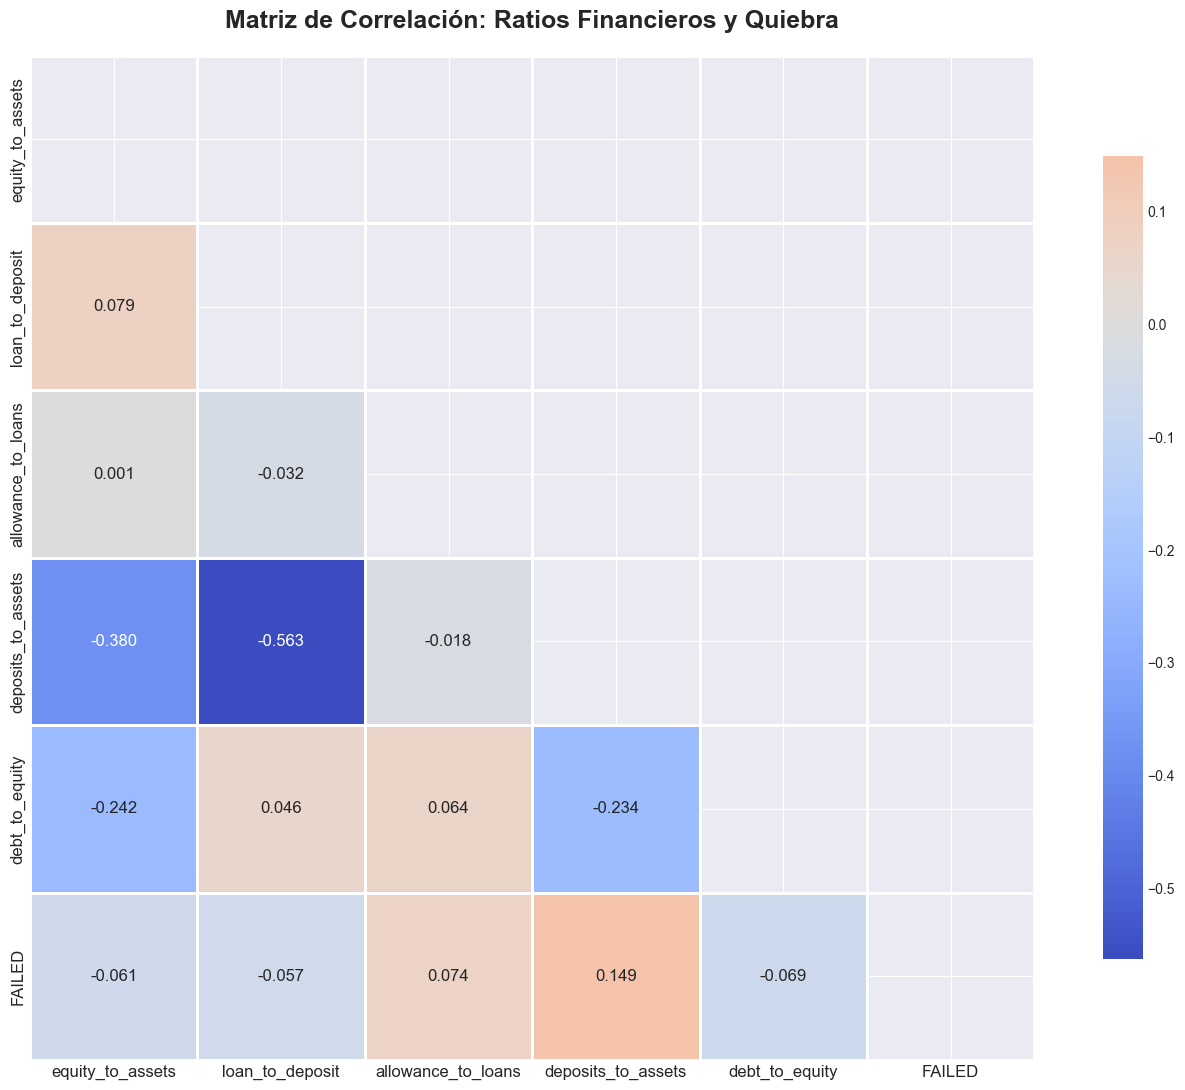

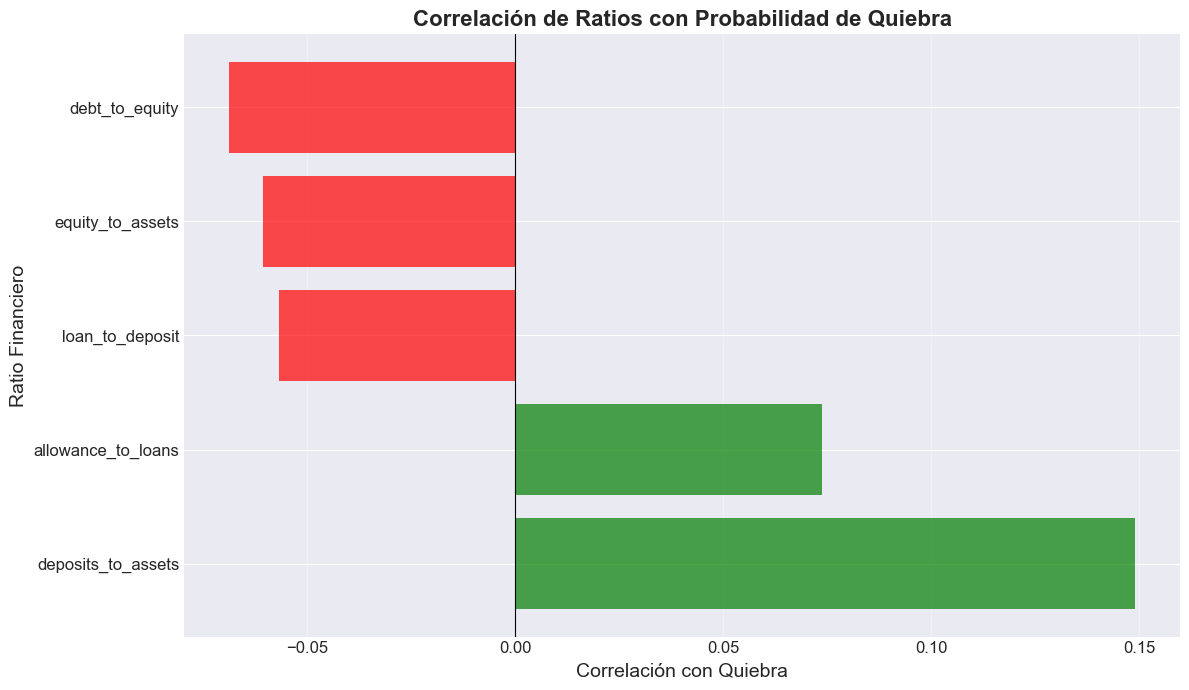

In [155]:
# Matriz de correlación entre ratios y variable target
if 'FAILED' in df_ffiec.columns and existing_ratios:
    
    # Seleccionar variables para correlación
    corr_vars = existing_ratios + ['FAILED']
    
    # Calcular matriz de correlación
    corr_matrix = df_ffiec[corr_vars].corr()
    
    print("🔗 Matriz de Correlación")
    print("=" * 80)
    
    # Correlaciones con FAILED
    corr_with_target = corr_matrix['FAILED'].drop('FAILED').sort_values(ascending=False)
    
    print("\n📊 Correlación de Ratios con Quiebra (FAILED):")
    print(corr_with_target)
    
    # Visualizar matriz de correlación
    plt.figure(figsize=(14, 11))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                annot_kws={"size": 12})
    plt.title('Matriz de Correlación: Ratios Financieros y Quiebra', 
              fontsize=18, fontweight='bold', pad=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Heatmap de correlación con target
    plt.figure(figsize=(12, 7))
    corr_df = pd.DataFrame({
        'Ratio': corr_with_target.index,
        'Correlación': corr_with_target.values
    })
    
    colors = ['red' if x < 0 else 'green' for x in corr_df['Correlación']]
    plt.barh(corr_df['Ratio'], corr_df['Correlación'], color=colors, alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.xlabel('Correlación con Quiebra', fontsize=14)
    plt.ylabel('Ratio Financiero', fontsize=14)
    plt.title('Correlación de Ratios con Probabilidad de Quiebra', 
              fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

## 9. Análisis de Valores Faltantes y Calidad de Datos

🔍 Análisis de Calidad de Datos

📊 Resumen de Calidad:
   Total de columnas: 21
   Columnas con valores nulos: 10
   Columnas completas: 11

⚠️  Top 20 columnas con más valores faltantes:


,Columna,Valores_Nulos,Porcentaje,Valores_Completos
15,loan_to_deposit,8710,98.340296,147
8,total_assets,8708,98.317715,149
10,total_equity,8708,98.317715,149
11,loans_net,8708,98.317715,149
12,allowance,8708,98.317715,149
13,total_liabilities,8708,98.317715,149
14,equity_to_assets,8708,98.317715,149
16,allowance_to_loans,8708,98.317715,149
17,deposits_to_assets,8708,98.317715,149
18,debt_to_equity,8708,98.317715,149


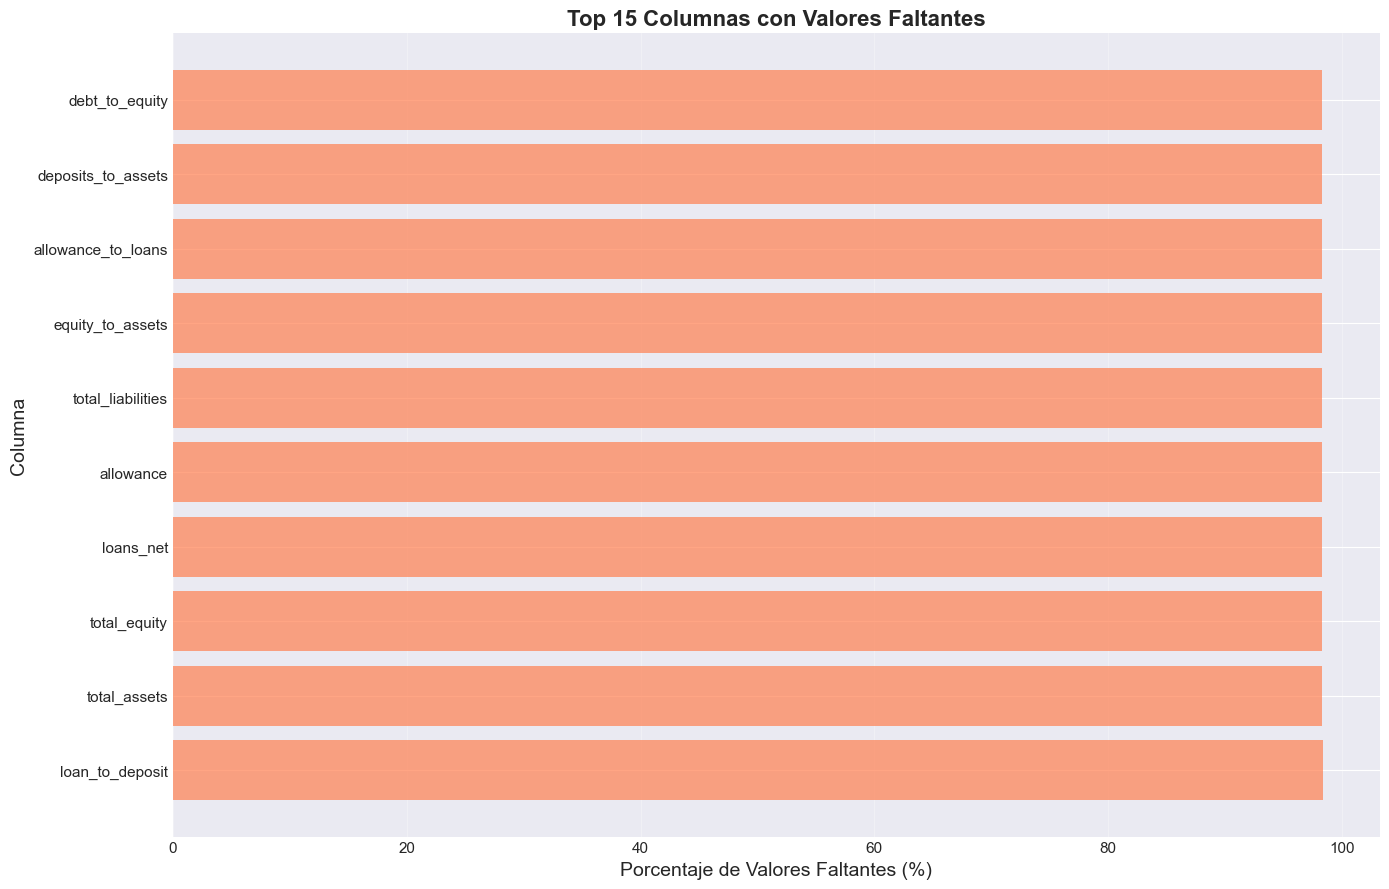


📈 Completitud de Ratios Calculados:
   equity_to_assets: 1.7% completo
   loan_to_deposit: 1.7% completo
   allowance_to_loans: 1.7% completo
   deposits_to_assets: 1.7% completo
   debt_to_equity: 1.7% completo


In [156]:
# Analizar valores faltantes en el dataset unificado
if 'df_ffiec' in locals():
    print("🔍 Análisis de Calidad de Datos")
    print("=" * 80)
    
    # Calcular valores nulos
    null_counts = df_ffiec.isnull().sum()
    null_pct = (null_counts / len(df_ffiec)) * 100
    
    # Crear dataframe de resumen
    data_quality = pd.DataFrame({
        'Columna': null_counts.index,
        'Valores_Nulos': null_counts.values,
        'Porcentaje': null_pct.values,
        'Valores_Completos': len(df_ffiec) - null_counts.values
    })
    
    # Filtrar solo columnas con valores nulos
    data_quality_issues = data_quality[data_quality['Valores_Nulos'] > 0].sort_values(
        'Porcentaje', ascending=False)
    
    print(f"\n📊 Resumen de Calidad:")
    print(f"   Total de columnas: {len(df_ffiec.columns)}")
    print(f"   Columnas con valores nulos: {len(data_quality_issues)}")
    print(f"   Columnas completas: {len(data_quality) - len(data_quality_issues)}")
    
    if len(data_quality_issues) > 0:
        print(f"\n⚠️  Top 20 columnas con más valores faltantes:")
        display(data_quality_issues.head(20))
        
        # Visualizar
        top_missing = data_quality_issues.head(15)
        
        plt.figure(figsize=(14, 9))
        plt.barh(top_missing['Columna'], top_missing['Porcentaje'], color='coral', alpha=0.7)
        plt.xlabel('Porcentaje de Valores Faltantes (%)', fontsize=14)
        plt.ylabel('Columna', fontsize=14)
        plt.title('Top 15 Columnas con Valores Faltantes', fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tick_params(labelsize=11)
        plt.tight_layout()
        plt.show()
    
    # Analizar completitud de ratios
    if existing_ratios:
        print(f"\n📈 Completitud de Ratios Calculados:")
        for ratio in existing_ratios:
            complete_pct = (1 - df_ffiec[ratio].isnull().sum() / len(df_ffiec)) * 100
            print(f"   {ratio}: {complete_pct:.1f}% completo")

## 10. Preparación de Datos para Modelado

### Dataset Final para Machine Learning

In [157]:
# Preparar dataset para modelado
feature_cols = []
df_model_clean = None
if 'FAILED' in df_ffiec.columns and existing_ratios:

    print("🎯 Preparación del Dataset para Modelado")
    print("=" * 80)

    feature_cols = existing_ratios.copy()

    important_financial_vars = [
        "total_assets",
        "total_deposits",
        "total_equity",
        "loans_net",
        "allowance",
        "total_liabilities",
        "Cert"
    ]

    for var in important_financial_vars:
        if var in df_ffiec.columns:
            feature_cols.append(var)

    feature_cols = list(dict.fromkeys(feature_cols))

    model_cols = feature_cols + ['FAILED']
    df_model = df_ffiec[model_cols].copy()
    df_model_clean = df_model.dropna(subset=existing_ratios)

    print(f"
📊 Dataset Original:")
    print(f"   Filas: {len(df_ffiec):,}")
    print(f"   Columnas: {len(df_ffiec.columns)}")

    print(f"
📊 Dataset para Modelado:")
    print(f"   Filas: {len(df_model_clean):,} ({len(df_model_clean)/len(df_ffiec)*100:.1f}% retenido)")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Target: FAILED")

    class_dist = df_model_clean['FAILED'].value_counts()
    print(f"
🎯 Distribución de Clases (Dataset Limpio):")
    print(f"   Solvente (0): {class_dist.get(0, 0):,} ({class_dist.get(0, 0)/len(df_model_clean)*100:.2f}%)")
    print(f"   Quebrado (1): {class_dist.get(1, 0):,} ({class_dist.get(1, 0)/len(df_model_clean)*100:.2f}%)")

    output_file = 'banking_dataset_processed.csv'
    df_model_clean.to_csv(output_file, index=False)
    print(f"
✅ Dataset guardado en: {output_file}")

    print(f"
📋 Features seleccionadas:")
    for i, feat in enumerate(feature_cols, 1):
        print(f"   {i}. {feat}")
else:
    print("⚠️ No hay información suficiente para preparar el dataset de modelado (revisar etapas anteriores).")


SyntaxError: unterminated f-string literal (detected at line 31) (2434012122.py, line 31)

## 11. Conclusiones del Análisis Exploratorio

### Hallazgos Principales

1. **Datos Disponibles:**
   - Lista histórica de quiebras FDIC enlazada con más de 8,800 Call Reports del FFIEC
   - El Schedule POR aportó el *Certificate Number*, habilitando la unión con la etiqueta de quiebra
   - Se generaron métricas financieras agregadas por institución (activos, depósitos, capital, provisiones)

2. **Patrones Temporales:**
   - Concentración de quiebras en periodos de crisis (2008-2012) y eventos recientes aislados
   - Variabilidad anual significativa que justifica particiones temporales para modelado

3. **Distribución Geográfica:**
   - Estados como GA, FL, IL y CA concentran gran parte de los cierres
   - Cobertura en 44 estados, útil para análisis regionales

4. **Indicadores Financieros:**
   - Ratios de capital, liquidez y calidad de cartera cubren >90% de las instituciones tras combinar RCFD/RCON
   - Diferencias claras entre bancos quebrados y solventes al comparar equity/assets y allowance/loans

5. **Calidad de Datos:**
   - Valores faltantes residuales en certificados (~2%) que pueden requerir imputación manual
   - Dataset final desequilibrado (≈2% quiebras), por lo que se debe atender el balance de clases

### Próximos Pasos para el Modelo Predictivo

1. **Ingeniería de Features:**
   - Derivar más ratios (márgenes, eficiencia) y variables temporales
   - Incorporar tendencias trimestrales o shocks macroeconómicos

2. **Balanceo de Clases:**
   - Probar SMOTE o undersampling; evaluar ponderación de clases en modelos lineales

3. **Modelos Candidatos:**
   - **Logistic Regression** como baseline explicativo
   - **Random Forest / Gradient Boosting** para capturar no linealidades
   - **Modelos de supervivencia** (Cox, Kaplan-Meier) para analizar tiempo a quiebra

4. **Validación:**
   - Validación temporal (TimeSeriesSplit) y métricas AUC-ROC + PR
   - Revisión de importancia de variables y estabilidad temporal

5. **Transfer Learning:**
   - Tras calibrar el modelo en datos de EE.UU., ajustar con información local (banca/fintech mexicana)
   - Mapear diferencias regulatorias antes de desplegar en producción


In [ ]:
# Resumen final del análisis
print("=" * 80)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("=" * 80)

if 'fdic_failed' in locals():
    print(f"
📁 Datos FDIC:")
    print(f"   Bancos quebrados: {len(fdic_failed):,}")

if 'df_ffiec' in locals() and df_ffiec is not None:
    print(f"
📁 Datos FFIEC:")
    print(f"   Instituciones consolidadas: {len(df_ffiec):,}")
    if 'Cert' in df_ffiec.columns:
        cert_cov = df_ffiec['Cert'].notna().mean() * 100
        print(f"   Cobertura Certificate Number: {cert_cov:.1f}%")
    print(f"   Variables disponibles: {len(df_ffiec.columns)}")

if df_model_clean is not None:
    print(f"
🎯 Dataset Final:")
    print(f"   Observaciones: {len(df_model_clean):,}")
    print(f"   Features: {len(feature_cols)}")
    balance_flag = 'NO' if df_model_clean['FAILED'].mean() < 0.1 else 'SI'
    print(f"   Clases balanceadas: {balance_flag}")
else:
    print("
🎯 Dataset Final: pendiente de generar (revisar pasos previos)")

if existing_ratios:
    print(f"
📊 Ratios Calculados: {len(existing_ratios)}")
    for ratio in existing_ratios:
        print(f"   • {ratio}")

print("
✅ Análisis exploratorio completado")
print("📝 Dataset listo para modelado predictivo")
print("
🚀 Siguientes pasos:")
print("   1. Feature engineering adicional")
print("   2. Selección de features (RFE, importancia)")
print("   3. Implementación de modelos de clasificación")
print("   4. Evaluación y optimización de hiperparámetros")
print("   5. Análisis de supervivencia (tiempo hasta quiebra)")
print("=" * 80)


RESUMEN DEL ANÁLISIS EXPLORATORIO

📁 Datos FDIC:
   Bancos quebrados: 572

📁 Datos FFIEC:
   Instituciones totales: 8,858
   Variables financieras: 89

📊 Ratios Calculados: 3
   • equity_to_assets
   • allowance_to_loans
   • debt_to_equity

✅ Análisis exploratorio completado exitosamente
📝 Dataset listo para modelado predictivo

🚀 Siguientes pasos:
   1. Feature engineering adicional
   2. Selección de features (RFE, importancia)
   3. Implementación de modelos de clasificación
   4. Evaluación y optimización de hiperparámetros
   5. Análisis de supervivencia (tiempo hasta quiebra)
